# Weighted Histogram Analysis Method (WHAM) for free energy calculations.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
def flat(x_vals):
    return np.zeros_like(x_vals)

def w_shape(x_vals):
    return x_vals**4 - 0.85*x_vals**2

def barrier(x_vals):
    return 100*x_vals**4 - 100*x_vals**2

class Dynamics():
    def __init__(self, fes_func):
        self.x_vals = np.linspace(-1,1,100)
        self.bin_width = self.x_vals[1] - self.x_vals[0]
        self.fes_func = fes_func
        self.underlying_fes = fes_func(self.x_vals)
        
        self.boltz_weights = np.exp(-self.underlying_fes)

        self.underlying_prob_dist = self.boltz_weights / (np.sum(self.boltz_weights)*self.bin_width)

    def dynamics(self,nsteps):
        x_index = np.random.randint(0,len(self.x_vals))
        # x_index = np.where(self.underlying_fes == self.underlying_fes.min())[0][0]
        coord = self.x_vals[x_index]
        self.time = [0]
        self.trajectory = [coord]
        num_acceptances = 0

        for i in range(nsteps):
            rand = np.random.rand()
            self.time.append(i+1)
            
            if rand >= 0.5:
                # Impose PBC
                if (x_index + 1) == 100:
                    trial_index = 0

                else:
                    trial_index = x_index + 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            else:
                # Impose PBC
                if (x_index - 1) == -1:
                    trial_index = 99

                else:
                    trial_index = x_index - 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            coord = self.x_vals[x_index]
            
            self.trajectory.append(coord)
        
        self.acceptance_prob = num_acceptances / nsteps

class Umbrella_sampling():
    def __init__(self,numbrellas,kappa,fes_func):
        self.numbrellas = numbrellas
        self.centers = np.linspace(-1,1,numbrellas)
        self.replicas = []
        for i in range(numbrellas):
            replica_window = Dynamics(fes_func)
            replica_window.underlying_fes += self.harmonic_restraint((replica_window.x_vals),(self.centers[i]),kappa)
            replica_window.boltz_weights = np.exp(-replica_window.underlying_fes)
            replica_window.underlying_prob_dist = replica_window.boltz_weights / (np.sum(replica_window.boltz_weights)*replica_window.bin_width)
            self.replicas.append(copy.deepcopy(replica_window))

    def dynamics(self,nsteps):
        for i in range(self.numbrellas):
            self.replicas[i].dynamics(nsteps)
        
    
    def harmonic_restraint(self,x_vals,center,kappa):
        return 0.5 * kappa * (x_vals - center)**2



In [5]:
umb = Umbrella_sampling(15,500,barrier)
umb.dynamics(100000)

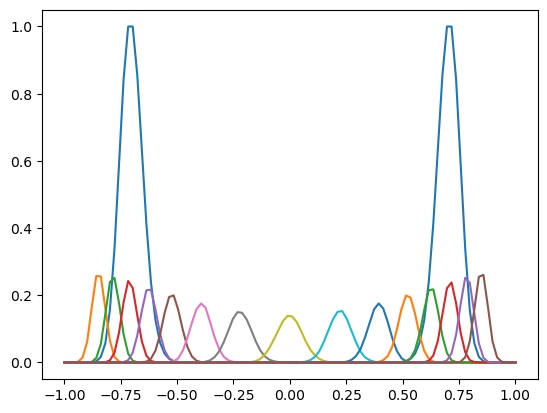

In [6]:
x_vals = umb.replicas[0].x_vals
fes = barrier(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
plt.plot(x_vals, prob_dist)

for i in range(umb.numbrellas):
    hist, _ = np.histogram(umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/hist.sum()
    plt.plot(x_vals,hist)


In [ ]:
dyn = Dynamics(barrier)
dyn.dynamics(10000000)

print(dyn.acceptance_prob)
plt.plot(dyn.time,dyn.trajectory)
plt.ylim(-1,1)


In [ ]:
hist, _ = np.histogram(dyn.trajectory,range=(-1,1),bins=100)

prob_hist = hist/hist.sum()

plt.plot(dyn.x_vals,dyn.underlying_prob_dist,label='Underlying Probability Distribution')
plt.plot(dyn.x_vals,prob_hist,label='Probability Distribution from Dynamics')
plt.legend()

In [ ]:
sampled_fes = -np.log(prob_hist)
plt.plot(dyn.x_vals,dyn.underlying_fes-dyn.underlying_fes.min())
plt.plot(dyn.x_vals,sampled_fes-sampled_fes.min())